#  **ICT303 - Assignment 2**

**Your name: <enter here your full name>**

**Student ID: <enter here your student ID>** 

**Email: <enter here your email address>** 

In this assignment, you will build a deep learning model for identifying $120$ different breeds of dogs. Similar to the previous assignment, you will use real images from the [Kaggle competition](https://www.kaggle.com/c/dog-breed-identification). 

In this assignment, your are required to use a ResNet network. You can use ResNet implementation provided in PyTorch. Note however  that there are many versions of ResNet (they differ in terms of number of layers). Your task is to find the best configuration that gives the best performance. 

The rule is similar to the previous assignment:

1. Develop a better model to reduce the recognition error.  
2. Submit your results to Kaggle and take a sceenshot of your score. Then insert here the screenshot of your result. 

It is important that you start as earlier as possible. Tuning hyper-parameters takes time, and Kaggle limits the number of submissions per day.

The top 3 students in the Kaggle ranking will be invited for a coffee!

## **0. Pre-requisites**



Import all relevant libraries for use

In [1]:
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

Checks to see if CUDA GPUs are available. They are more effective in computational runs for this assignment

In [2]:
# Use cuda if possible (computationally more effective than cpu)
if torch.cuda.is_available():
    device_name = torch.device("cuda")
else:
    device_name = torch.device('cpu')
print("Using {}.".format(device_name))

device_count = torch.cuda.device_count()
print("Number of available GPUs:", device_count)

Using cpu.
Number of available GPUs: 0


## **1. Obtaining and Organizing the Data Set**

The competition data is divided into a training set and testing set:
- The training set contains $10,222$ color images.
- The testing set contains $10,357$ color images. 

The images in both sets are in JPEG format. Each image contains three channels (R, G and B). The images have  different heights and widths.

There are $120$ breeds of dogs in the training set, e.g., *Labradors, Poodles, Dachshunds,
Samoyeds, Huskies, Chihuahuas, and Yorkshire Terriers*.

### **1.1. Directory of Data Set**

Change below to the path where the data is located then run.

For example, if the data is on a subdirectory of the current folder then './DataFolder'.

In [3]:
data_dir = '../MLData-dog-breed-image-recognition'

### **1.2. Organizing the Data Set**

Next, we define the reorg_train_valid function to split the validation set from the original Kaggle competition training set. The parameter valid_ratio in this function is the ratio of the number of examples of each dog breeds in the validation set to the number of examples of the
breed with the least examples (66) in the original training set. 

After organizing the data, images of the same breed will be placed in the same folder so that we can read them later.

In [4]:
def reorg_dog_data(data_dir, valid_ratio):
    labels = d2l.read_csv_labels(os.path.join(data_dir, 'labels.csv'))
    d2l.reorg_train_valid(data_dir, labels, valid_ratio)
    d2l.reorg_test(data_dir)


batch_size = 32 #if demo else 128
valid_ratio = 0.1
reorg_dog_data(data_dir, valid_ratio)

The `reorg_dog_data` function below is used to read the training data labels, segment the validation set, and organize the training set.

During actual training and testing, we would use the entire Kaggle Competition data set and call the reorg_dog_data function to organize the data set. Likewise, we would need to set the batch_size to a larger integer, such as 128.

## **2. Image Augmentation**

Images in training set are augmented to provide more data. Here's some reasoning and thoughts for the method chosen:

1. `Resize((256, 256))`: Resizes every image to be 256x256 pixels. Should ensure uniformity in image sizes.

2. `RandomHorizontalFlip()`: This function flips the image horizontally with 50% probability. This includes left-right mirrored versions of the images and should help increase the diversity of the dog poses that the model sees.

3. `RandomRotation(15)`: Randomly rotates image clockwise or counter-clockwise by up to 15 degrees. Not a lot of changes but it should allow the model to learn and recognize dog breeds even if they are slightly tilted in the image.

4. `CenterCrop(224)`: After augmentation, deterministic center crop is applied to obtain an image of size 224x224.

In [ ]:
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256)), # Resize the image to 256x256
    torchvision.transforms.RandomHorizontalFlip(), # Flip the image with a 50% chance
    torchvision.transforms.RandomRotation(15), # Rotate the image by a random angle between -15 and 15 degrees
    torchvision.transforms.CenterCrop(224), # Crop the center of the image
    torchvision.transforms.ToTensor(), # Convert the image to a tensor
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalize the image
])

For the test images, only simple resizing, center cropping, tensor conversion, and normalization are used, because during testing we don't want any randomness or augmentation. We only want to see how the model performs on the original untouched images.

In [ ]:
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])

## **3. Loading (Reading) the Data Set**

Similar to previous labs, write here the Python code tat reads the training, validation and test set.

In [ ]:
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]

In [ ]:
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

In [ ]:
def get_net(devices):
    finetune_net = nn.Sequential()
    finetune_net.features = torchvision.models.resnet34(pretrained=True)
    # Define a new output network (there are 120 output categories)
    finetune_net.output_new = nn.Sequential(nn.Linear(1000, 256),
                                            nn.ReLU(),
                                            nn.Linear(256, 120))
    # Move the model to devices if devices is not empty
    if devices:
        finetune_net = finetune_net.to(devices[0])
    # Freeze parameters of feature layers
    for param in finetune_net.features.parameters():
        param.requires_grad = False
    return finetune_net

In [ ]:
loss = nn.CrossEntropyLoss(reduction='none')

def evaluate_loss(data_iter, net, devices):
    l_sum, n = 0.0, 0
    for features, labels in data_iter:
        if len(devices) > 0:
            features, labels = features.to(devices[0]), labels.to(devices[0])
        outputs = net(features)
        l = loss(outputs, labels)
        l_sum += l.sum()
        n += labels.numel()
    return l_sum / n

## **4. Defining and Training ResNet**

Here, you are required to use ResNet to recognise the breed of the dogs in the images. You need to write the class that defines the network, the training class and the code for training the network. You are not required to implement ResNet from scratch. Instead, use PyTorch's implementation of ResNet. 

Note that there are many versions of ResNet. They differ in the number of layers they use. You are required to test with at least 2 versions and report their respective performances. 

Note that you are required to follow the good practices when training your network. In particular, you need to look at the loss curves (training and validation losses).

In [ ]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    # Only train the small custom output network
    if len(devices) > 0:
        net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.SGD((param for param in net.parameters()
                               if param.requires_grad), lr=lr,
                              momentum=0.9, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss']
    if valid_iter is not None:
        legend.append('valid loss')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(2)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            if len(devices) > 0:
                features, labels = features.to(devices[0]), labels.to(devices[0])
            trainer.zero_grad()
            output = net(features)
            l = loss(output, labels).sum()
            l.backward()
            trainer.step()
            metric.add(l, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1], None))
        measures = f'train loss {metric[0] / metric[1]:.3f}'
        if valid_iter is not None:
            valid_loss = evaluate_loss(valid_iter, net, devices)
            animator.add(epoch + 1, (None, valid_loss.detach().cpu()))
        scheduler.step()
    if valid_iter is not None:
        measures += f', valid loss {valid_loss:.3f}'
    print(measures + f'\n{metric[1] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

train loss 1.072, valid loss 1.614
27.7 examples/sec on []


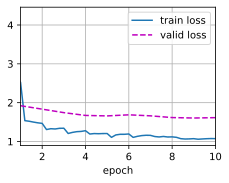

In [ ]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 10, 1e-4, 1e-4
lr_period, lr_decay, net = 2, 0.9, get_net(devices)
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

## **6. Run on the Testing Set and Submit the Results on Kaggle**

Finally, test your trained model on the test set and upload the results to the [Kaggle competition](https://www.kaggle.com/c/dog-breed-identification). 

You are required to submit a screenshot of your score.

train loss 1.061
29.0 examples/sec on []


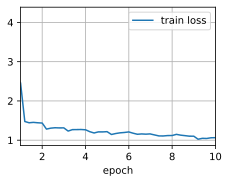

In [ ]:
net = get_net(devices)
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

preds = []
for data, label in test_iter:
    if len(devices) > 0:
        data = data.to(devices[0])
    output = torch.nn.functional.softmax(net(data), dim=1)
    preds.extend(output.cpu().detach().numpy())
ids = sorted(os.listdir(
    os.path.join(data_dir, 'train_valid_test', 'test', 'unknown')))
with open('submission.csv', 'w') as f:
    f.write('id,' + ','.join(train_valid_ds.classes) + '\n')
    for i, output in zip(ids, preds):
        f.write(i.split('.')[0] + ',' + ','.join(
            [str(num) for num in output]) + '\n')

## **7. Hints to Improve Your Results**
- Try to increase the batch size and the number of epochs.
- Try deeper ResNet networks.
